In [10]:
from sklearn.ensemble import (RandomForestRegressor, IsolationForest, GradientBoostingRegressor, AdaBoostRegressor)
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (StandardScaler, OneHotEncoder, FunctionTransformer, KBinsDiscretizer, RobustScaler)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt  # Matlab-style plotting
from sklearn.model_selection import GridSearchCV
import AveragedModels as av
import numpy as np
import xgboost as xgb
from sklearn.kernel_ridge import KernelRidge
import ml_helper as mlh
import lightgbm as lgb
from mlxtend.regressor import StackingCVRegressor

In [11]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')


In [12]:
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))


The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 


In [13]:
#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))


The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


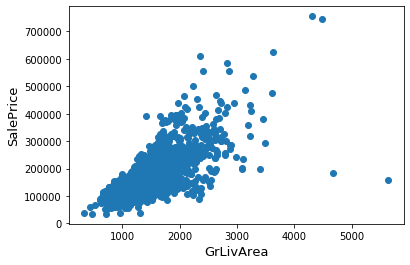

In [14]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

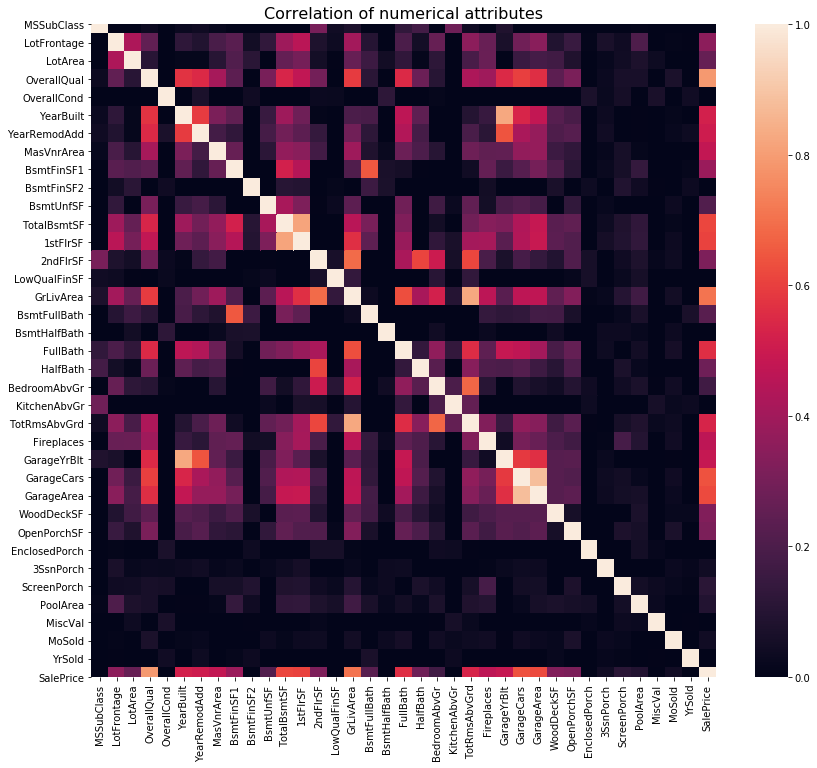

In [15]:
mlh.plotCoorelations(train, False)

In [16]:
train.corr()['SalePrice'].sort_values(ascending=False).head(15)


SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
Name: SalePrice, dtype: float64

In [17]:
# drop outliers detected visually
train = train.drop(train[(train["GrLivArea"] > 4000) & (train["SalePrice"] < 300000)].index)
print(train.shape)

(1458, 80)


In [18]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test), sort = False).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


In [19]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageFinish,5.450806
GarageYrBlt,5.450806
GarageQual,5.450806
GarageCond,5.450806


In [20]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
    
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
    
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
    
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
    
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data = all_data.drop(['Utilities'], axis=1)
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [21]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [22]:
print(all_data.shape)

# drop features based on coorelation analysis
features_to_drop = ["MSSubClass", "MoSold",
                    "YrSold", "MiscVal",
                    "BsmtFinSF2", "BsmtUnfSF", 
                    "LowQualFinSF", "GarageYrBlt",
                    "GarageArea"]

all_data.drop(features_to_drop, axis = 1, inplace = True)
print(all_data.shape)

(2917, 79)
(2917, 70)


In [23]:
from scipy.stats import norm, skew #for some statistics
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
PoolArea,17.688664
LotArea,13.109495
3SsnPorch,11.372080
KitchenAbvGr,4.300550
EnclosedPorch,4.002344
ScreenPorch,3.945101
BsmtHalfBath,3.929996
MasVnrArea,2.621719
OpenPorchSF,2.529358
WoodDeckSF,1.844792


In [ ]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)

In [ ]:
#fitting and prediction
train = Xt[:ntrain]
test = Xt[ntrain:]

In [ ]:
# try xgboost\n",
xgb_model = xgb.XGBRegressor(colsample_bytree=0.8, subsample=0.5,
                            learning_rate=0.05, max_depth=5,
                              min_child_weight=1.8, n_estimators=500,
                               reg_alpha=0.7, reg_lambda=0.7, gamma=0.001, 
                              silent=1, random_state =7, nthread = -1, refit = True)

mlh.crossValidateModel(xgb_model, train, y_train, "xgboost") 

In [ ]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=11,
                                 learning_rate=0.05, n_estimators=720,
                                 max_bin = 55, bagging_fraction = 0.8,
                                 bagging_freq = 4, feature_fraction = 0.3,
                                 feature_fraction_seed=9, bagging_seed=9,
                                 min_data_in_leaf =8, min_sum_hessian_in_leaf = 7)

mlh.crossValidateModel(model_lgb, train, y_train, "lightgbm", 1) # 1 job

In [ ]:
GBoost = GradientBoostingRegressor(n_estimators=2500, learning_rate=0.05,
                                       max_depth=3, max_features='sqrt',
                                       min_samples_leaf=11, min_samples_split=10, 
                                       loss='huber', random_state =5)

mlh.crossValidateModel(GBoost, train, y_train, "gboost") 

In [ ]:
#averaged_models = av.AveragingModels(models = (GBoost, model_lgb))
from sklearn.linear_model import (ElasticNet, Ridge, Lasso)
averaged_models = av.StackingAveragedModels(base_models = (GBoost, model_lgb, xgb_model), meta_model = Lasso(alpha = 0.1))

averaged_models.fit(train, y_train)

#make predictions which we will submit. 
y_pred = averaged_models.predict(test)

#The lines below shows how to save predictions in format used for competition scoring
output = pd.DataFrame({'Id': test_ID,
                       'SalePrice': y_pred})
output.to_csv('../data/submission.csv', index=False)

In [ ]:
# Set the parameters by cross-validation
param_grid = [{'n_estimators': [500, 600, 700], 'min_data_in_leaf': [4, 6, 8],
                     'min_sum_hessian_in_leaf': [7, 9, 11, 13]},
                    ]

grid_search = GridSearchCV(model_lgb, param_grid, scoring = "neg_mean_absolute_error", n_jobs = 1, verbose = 10, cv = 5)
grid_search.fit(train,y_train)
print(grid_search.best_params_)